<a href="https://colab.research.google.com/github/zarathacia/ProjetMobile-SmartPersonalShopper/blob/main/Radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import sys    
path = '/content/gdrive/MyDrive/RADDet'

sys.path.append(path)


# link with Git

In [ ]:
!git config --global user.email "jiheddachraoui@outlook.fr"
!git config --global user.name "jiheddachraoui"


In [ ]:
!git clone https://github.com/jiheddachraoui/P2M.git



Cloning into 'P2M'...
On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.config/
	gdrive/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


**push**

In [ ]:
%cd P2M
!git add .

[Errno 2] No such file or directory: 'P2M'
/content/P2M


In [ ]:
!git commit -m "first c"

On branch master

Initial commit

nothing to commit


In [ ]:
!git push

**pull**

In [ ]:
!git pull

# Unzip DATA

In [ ]:
!unzip "/content/gdrive/MyDrive/RADDet_ckpt/RadarResNet.zip" -d "/content/gdrive/MyDrive/RADDet/logs"

Archive:  /content/gdrive/MyDrive/RADDet_ckpt/RadarResNet.zip
   creating: /content/gdrive/MyDrive/RADDet/logs/RadarResNet/
   creating: /content/gdrive/MyDrive/RADDet/logs/RadarResNet/cartesian_b_3lr_0.0001/
  inflating: /content/gdrive/MyDrive/RADDet/logs/RadarResNet/cartesian_b_3lr_0.0001/events.out.tfevents.1611795728.alpha.15208.16757.v2  
   creating: /content/gdrive/MyDrive/RADDet/logs/RadarResNet/cartesian_b_3lr_0.0001/ckpt/
  inflating: /content/gdrive/MyDrive/RADDet/logs/RadarResNet/cartesian_b_3lr_0.0001/ckpt/ckpt-20.data-00000-of-00001  
  inflating: /content/gdrive/MyDrive/RADDet/logs/RadarResNet/cartesian_b_3lr_0.0001/ckpt/ckpt-20.index  
  inflating: /content/gdrive/MyDrive/RADDet/logs/RadarResNet/cartesian_b_3lr_0.0001/ckpt/ckpt-19.index  
  inflating: /content/gdrive/MyDrive/RADDet/logs/RadarResNet/cartesian_b_3lr_0.0001/ckpt/checkpoint  
  inflating: /content/gdrive/MyDrive/RADDet/logs/RadarResNet/cartesian_b_3lr_0.0001/ckpt/ckpt-18.index  
  inflating: /content/gdriv

In [ ]:

!unzip "/content/gdrive/MyDrive/RADDet_DATASET/test/RAD/part_3.zip" -d "/content/gdrive/MyDrive/dataset/test/RAD"
!unzip "/content/gdrive/MyDrive/RADDet_DATASET/test/gt/part_3.zip" -d "/content/gdrive/MyDrive/dataset/test/gt"
!unzip "/content/gdrive/MyDrive/RADDet_DATASET/test/stereo_image/part_3.zip" -d "/content/gdrive/MyDrive/dataset/test/stereo_image"
!unzip "/content/gdrive/MyDrive/RADDet_DATASET/train/RAD/part_9.zip" -d "/content/gdrive/MyDrive/dataset/train/RAD"
!unzip "/content/gdrive/MyDrive/RADDet_DATASET/train/gt/part_9.zip" -d "/content/gdrive/MyDrive/dataset/train/gt"
!unzip "/content/gdrive/MyDrive/RADDet_DATASET/train/stereo_image/part_9.zip" -d "/content/gdrive/MyDrive/dataset/train/stereo_image"


# CA-CFAR

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Plot settings
plt.rcParams['figure.figsize'] = (20, 5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams.update({'font.size': 22})

peak_idx = [ 96 132]


Text(0, 0.5, 'y')

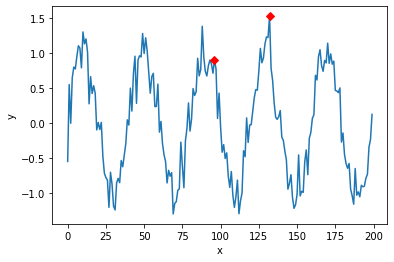

In [ ]:
def detect_peaks(x, num_train, num_guard, rate_fa):
    """
    Detect peaks with CFAR algorithm.
    
    num_train: Number of training cells.
    num_guard: Number of guard cells.
    rate_fa: False alarm rate. 
    """
    num_cells = x.size
    num_train_half = round(num_train / 2)
    num_guard_half = round(num_guard / 2)
    num_side = num_train_half + num_guard_half
 
    alpha = num_train*(rate_fa**(-1/num_train) - 1) # threshold factor
    
    peak_idx = []
    for i in range(num_side, num_cells - num_side):
        
        if i != i-num_side+np.argmax(x[i-num_side:i+num_side+1]): 
            continue
        
        sum1 = np.sum(x[i-num_side:i+num_side+1])
        sum2 = np.sum(x[i-num_guard_half:i+num_guard_half+1]) 
        p_noise = (sum1 - sum2) / num_train 
        threshold = alpha * p_noise
        
        if x[i] > threshold: 
            peak_idx.append(i)
    
    peak_idx = np.array(peak_idx, dtype=int)
    
    return peak_idx

y = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
x = np.arange(y.size)

# Detect peaks
peak_idx = detect_peaks(y, num_train=10, num_guard=2, rate_fa=0.15)
print("peak_idx =", peak_idx)

plt.plot(x, y)
plt.plot(x[peak_idx], y[peak_idx], 'rD')
plt.xlabel('x')
plt.ylabel('y')

# Train

In [ ]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import shutil
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
import json

import model.model as M
from dataset.batch_data_generator import DataGenerator
import metrics.mAP as mAP

import util.loader as loader
import util.helper as helper
import util.drawer as drawer


def main():
    ### NOTE: GPU manipulation, you may can print this out if necessary ###
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if len(gpus) > 0:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    config = loader.readConfig()
    config_data = config["DATA"]
    config_radar = config["RADAR_CONFIGURATION"]
    config_model = config["MODEL"]
    config_train = config["TRAIN"]

    anchor_boxes = loader.readAnchorBoxes() # load anchor boxes with order
    num_classes = len(config_data["all_classes"])

    ### NOTE: using the yolo head shape out from model for data generator ###
    model = M.RADDet(config_model, config_data, config_train, anchor_boxes)
    model.build([None] + config_model["input_shape"])
    model.summary()

    ### NOTE: preparing data ###
    data_generator = DataGenerator(config_data, config_train, config_model, \
                                model.features_shape, anchor_boxes)
    train_generator = data_generator.trainGenerator()
    validate_generator = data_generator.validateGenerator()

    ### NOTE: training settings ###
    logdir = os.path.join(config_train["log_dir"], \
                        "b_" + str(config_train["batch_size"]) + \
                        "lr_" + str(config_train["learningrate_init"]))
    if not os.path.exists(logdir):
        os.makedirs(logdir)
    global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
    optimizer = K.optimizers.Adam(learning_rate=config_train["learningrate_init"])
    writer = tf.summary.create_file_writer(logdir)
    ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model, step=global_steps)
    log_specific_dir = os.path.join(logdir, "ckpt")
    manager = tf.train.CheckpointManager(ckpt, log_specific_dir, max_to_keep=3)

    ### NOTE: restore from last checkpoint ###
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
        global_steps.assign(ckpt.step.numpy())

    ### NOTE: define training step ###
    @tf.function
    def train_step(data, label):
        """ define train step for training """
        with tf.GradientTape() as tape:
            feature = model(data)
            pred_raw, pred = model.decodeYolo(feature)
            total_loss, box_loss, conf_loss, category_loss = \
                model.loss(pred_raw, pred, label, raw_boxes[..., :6])
            gradients = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            ### NOTE: writing summary data ###
            with writer.as_default():
                tf.summary.scalar("lr", optimizer.lr, step=global_steps)
                tf.summary.scalar("loss/total_loss", total_loss, step=global_steps)
                tf.summary.scalar("loss/box_loss", box_loss, step=global_steps)
                tf.summary.scalar("loss/conf_loss", conf_loss, step=global_steps)
                tf.summary.scalar("loss/category_loss", category_loss, step=global_steps)
            writer.flush()
        return total_loss, box_loss, conf_loss, category_loss
 
    ### NOTE: define validate step ###
    # @tf.function
    def validate_step():
        mean_ap_test = 0.0
        ap_all_class_test = []
        ap_all_class = []
        total_losstest = []
        box_losstest = []
        conf_losstest = []
        category_losstest = []
        for class_id in range(num_classes):
            ap_all_class.append([])
        for data, label, raw_boxes in validate_generator.\
            batch(data_generator.batch_size).take(data_generator.total_validate_batches):
            feature = model(data)
            pred_raw, pred = model.decodeYolo(feature)
            total_loss_b, box_loss_b, conf_loss_b, category_loss_b = \
                model.loss(pred_raw, pred, label, raw_boxes[..., :6])
            total_losstest.append(total_loss_b)
            box_losstest.append(box_loss_b)
            conf_losstest.append(conf_loss_b)
            category_losstest.append(category_loss_b)
            for batch_id in range(raw_boxes.shape[0]):
                raw_boxes_frame = raw_boxes[batch_id]
                pred_frame = pred[batch_id]
                predicitons = helper.yoloheadToPredictions(pred_frame, \
                                    conf_threshold=config_model["confidence_threshold"])
                nms_pred = helper.nms(predicitons, config_model["nms_iou3d_threshold"], \
                                config_model["input_shape"], sigma=0.3, method="nms")
                mean_ap, ap_all_class = mAP.mAP(nms_pred, raw_boxes_frame.numpy(), \
                                        config_model["input_shape"], ap_all_class, \
                                        tp_iou_threshold=config_model["mAP_iou3d_threshold"])
                mean_ap_test += mean_ap
        for ap_class_i in ap_all_class:
            if len(ap_class_i) == 0:
                class_ap = 0.
            else:
                class_ap = np.mean(ap_class_i)
            ap_all_class_test.append(class_ap)
        mean_ap_test /= data_generator.batch_size*data_generator.total_validate_batches
        tf.print("-------> ap: %.6f"%(mean_ap_test))
        ### writing summary data ###
        with writer.as_default():
            tf.summary.scalar("ap/ap_all", mean_ap_test, step=global_steps)
            tf.summary.scalar("ap/ap_person", ap_all_class_test[0], step=global_steps)
            tf.summary.scalar("ap/ap_bicycle", ap_all_class_test[1], step=global_steps)
            tf.summary.scalar("ap/ap_car", ap_all_class_test[2], step=global_steps)
            tf.summary.scalar("ap/ap_motorcycle", ap_all_class_test[3], step=global_steps)
            tf.summary.scalar("ap/ap_bus", ap_all_class_test[4], step=global_steps)
            tf.summary.scalar("ap/ap_truck", ap_all_class_test[5], step=global_steps)
            ### NOTE: validate loss ###
            tf.summary.scalar("validate_loss/total_loss", \
                    np.mean(total_losstest), step=global_steps)
            tf.summary.scalar("validate_loss/box_loss", \
                    np.mean(box_losstest), step=global_steps)
            tf.summary.scalar("validate_loss/conf_loss", \
                    np.mean(conf_losstest), step=global_steps)
            tf.summary.scalar("validate_loss/category_loss", \
                    np.mean(category_losstest), step=global_steps)
        writer.flush()

    ###---------------------------- TRAIN SET -------------------------###
    for data, label, raw_boxes in train_generator.repeat().\
            batch(data_generator.batch_size).take(data_generator.total_train_batches):
        total_loss, box_loss, conf_loss, category_loss = train_step(data, label)
        tf.print("=======> train step: %4d, lr: %.6f, total_loss: %4.2f,  \
                box_loss: %4.2f, conf_loss: %4.2f, category_loss: %4.2f" % \
                (global_steps, optimizer.lr.numpy(), total_loss, box_loss, \
                conf_loss, category_loss))
        ### NOTE: learning rate decay ###
        global_steps.assign_add(1)
        if global_steps < config_train["warmup_steps"]:
            # lr = config_train["learningrate_init"]
            if global_steps < config_train["startup_steps"]:
                lr = config_train["learningrate_startup"]
            else:
                lr = config_train["learningrate_init"]
            optimizer.lr.assign(lr)
        elif global_steps % config_train["learningrate_decay_gap"] == 0:
            lr = optimizer.lr.numpy()
            lr = config_train["learningrate_end"] + \
                    config_train["learningrate_decay"] * \
                    (lr - config_train["learningrate_end"])
            optimizer.lr.assign(lr)
 
        ###---------------------------- VALIDATE SET -------------------------###
        if global_steps.numpy() >= config_train["validate_start_steps"] and \
                global_steps.numpy() % config_train["validate_gap"] == 0:
            validate_step()
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))


if __name__ == "__main__":
    main()



1 Physical GPUs, 1 Logical GPUs
--- backbone stage shape --- (None, 64, 64, 64)
--- backbone stage shape --- (None, 32, 32, 128)
--- backbone stage shape --- (None, 16, 16, 256)
Model: "rad_det"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 16, 16, 256)       6732672   
                                                                 
 model_1 (Functional)        (None, 16, 16, 4, 78)     8074936   
                                                                 
Total params: 8,074,936
Trainable params: 8,054,712
Non-trainable params: 20,224
_________________________________________________________________
Restored from /content/gdrive/MyDrive/RADDet/logs/RadarResNet/b_3lr_0.0001/ckpt/ckpt-20
=======> train step: 200000, lr: 0.000028, total_loss: 4.09,                  box_loss: 2.05, conf_loss: 1.84, category_loss: 0.19
=======> train step: 200001, lr: 0.000028, 

KeyboardInterrupt: ignored

# Visualize

  0%|          | 0/32 [00:00<?, ?it/s]

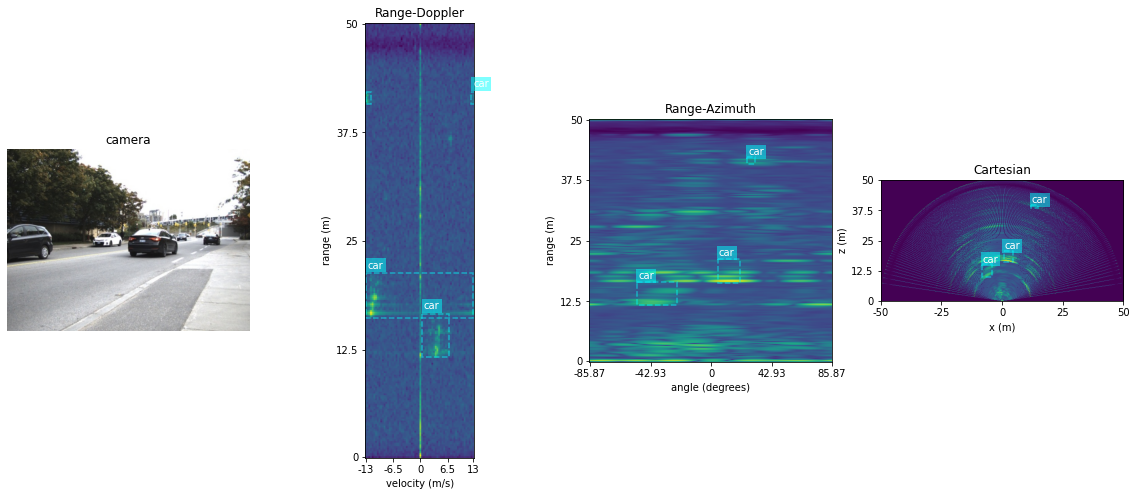

  3%|▎         | 1/32 [00:07<04:07,  7.97s/it]

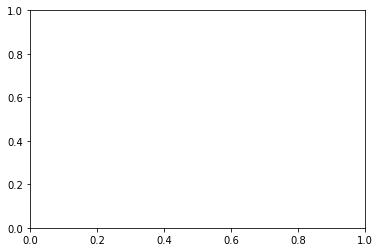

  6%|▋         | 2/32 [00:13<03:23,  6.79s/it]

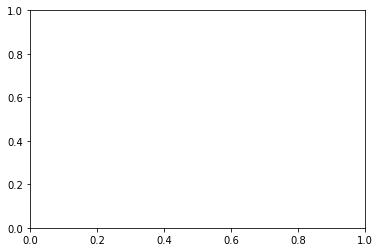

  9%|▉         | 3/32 [00:19<03:02,  6.30s/it]

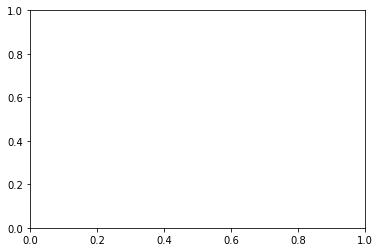

 12%|█▎        | 4/32 [00:25<02:49,  6.05s/it]

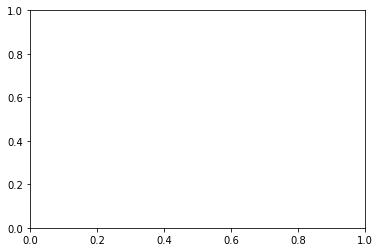

 16%|█▌        | 5/32 [00:30<02:38,  5.87s/it]

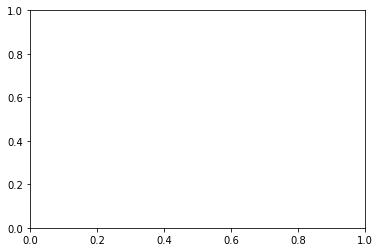

 19%|█▉        | 6/32 [00:36<02:29,  5.76s/it]

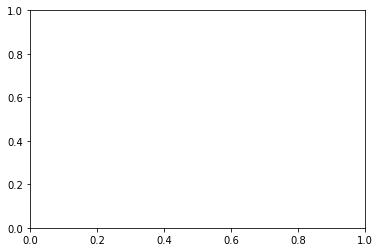

 22%|██▏       | 7/32 [00:42<02:23,  5.73s/it]

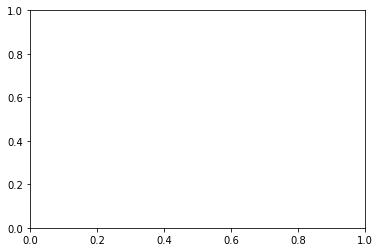

 25%|██▌       | 8/32 [00:47<02:17,  5.72s/it]

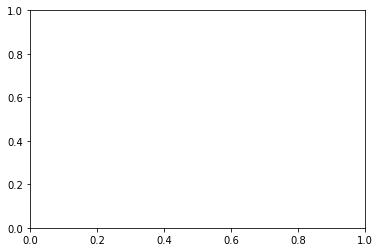

 28%|██▊       | 9/32 [00:53<02:11,  5.70s/it]

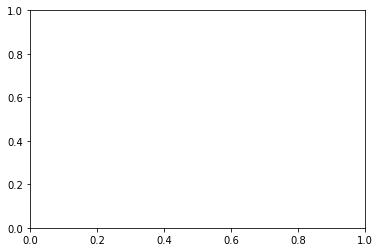

 31%|███▏      | 10/32 [00:59<02:04,  5.66s/it]

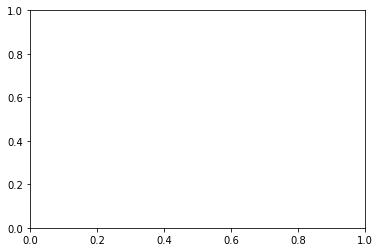

 34%|███▍      | 11/32 [01:04<01:58,  5.62s/it]

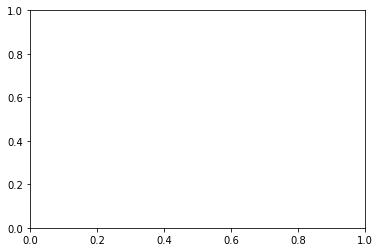

 38%|███▊      | 12/32 [01:10<01:52,  5.64s/it]

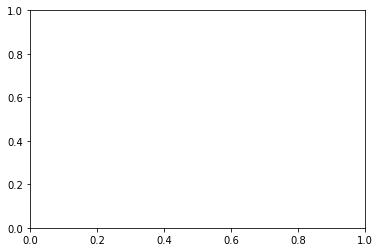

 41%|████      | 13/32 [01:15<01:47,  5.68s/it]

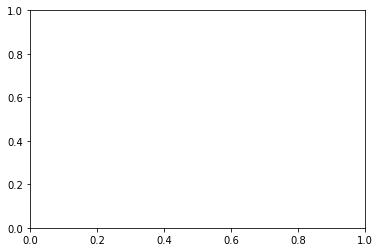

 44%|████▍     | 14/32 [01:21<01:43,  5.72s/it]

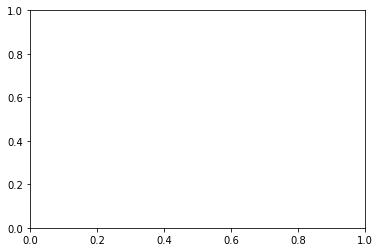

 47%|████▋     | 15/32 [01:27<01:38,  5.79s/it]

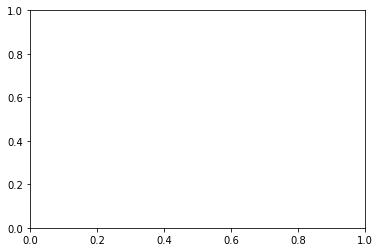

 50%|█████     | 16/32 [01:33<01:31,  5.71s/it]

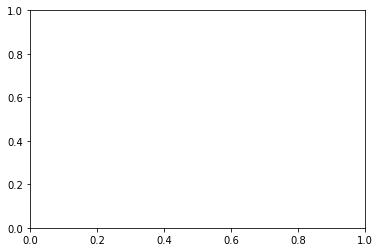

 53%|█████▎    | 17/32 [01:38<01:24,  5.65s/it]

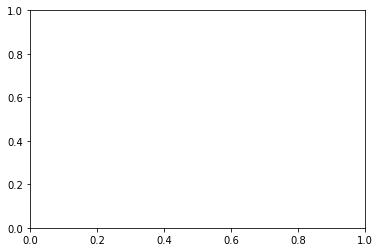

 56%|█████▋    | 18/32 [01:44<01:18,  5.64s/it]

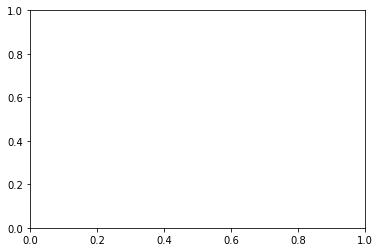

 59%|█████▉    | 19/32 [01:49<01:12,  5.59s/it]

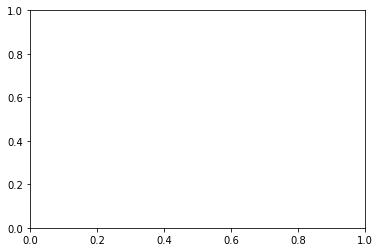

 62%|██████▎   | 20/32 [01:55<01:07,  5.60s/it]

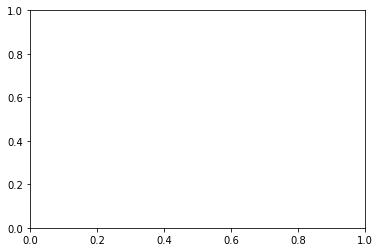

 66%|██████▌   | 21/32 [02:01<01:01,  5.57s/it]

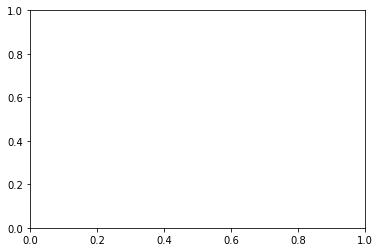

 69%|██████▉   | 22/32 [02:06<00:55,  5.57s/it]

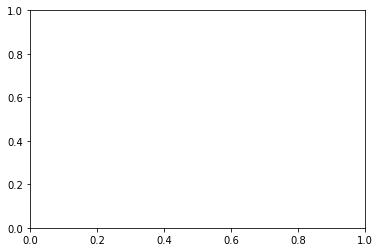

 72%|███████▏  | 23/32 [02:12<00:50,  5.58s/it]

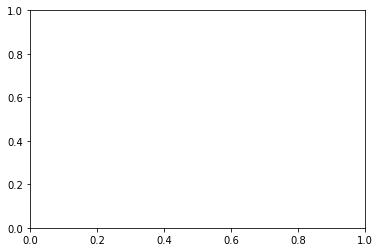

 75%|███████▌  | 24/32 [02:17<00:44,  5.61s/it]

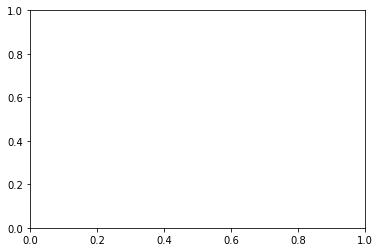

 78%|███████▊  | 25/32 [02:23<00:39,  5.63s/it]

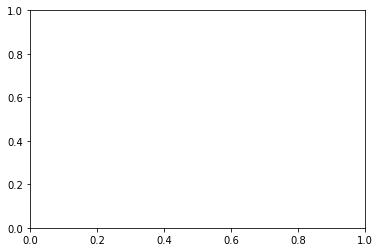

 81%|████████▏ | 26/32 [02:28<00:33,  5.55s/it]

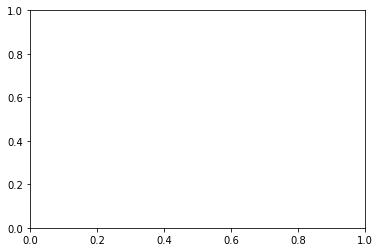

 84%|████████▍ | 27/32 [02:34<00:28,  5.61s/it]

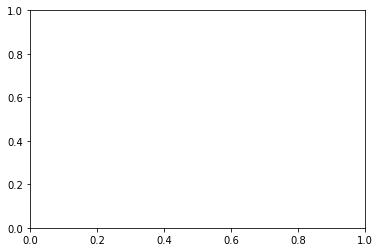

 88%|████████▊ | 28/32 [02:40<00:22,  5.58s/it]

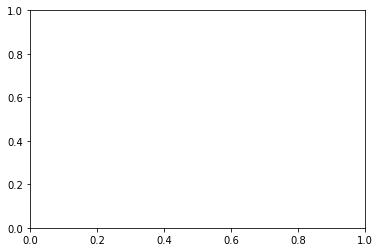

 91%|█████████ | 29/32 [02:45<00:16,  5.56s/it]

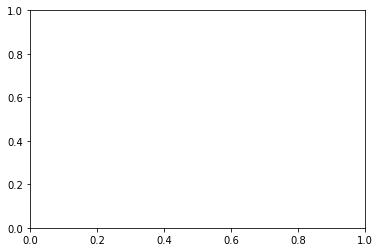

 94%|█████████▍| 30/32 [02:51<00:11,  5.53s/it]

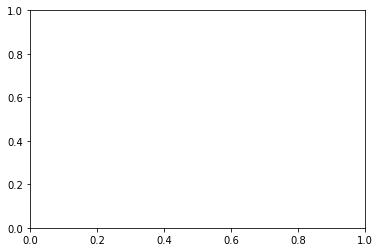

 97%|█████████▋| 31/32 [02:56<00:05,  5.50s/it]

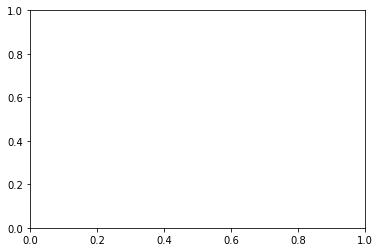

100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

import util.loader as loader
import util.helper as helper
import util.drawer as drawer

import multiprocessing as mp
from functools import partial

def cutImage(image_name):
    image = cv2.imread(image_name)
    part_1 = image[:, 1650:2550, :]
    part_2 = image[:, 3950:4250, :]
    part_3 = image[:, 5750:6500, :]
    part_4 = image[:, 7450:8850, :]
    new_img = np.concatenate([part_1, part_2, part_3, part_4], axis=1)
    cv2.imwrite(image_name, new_img)

def process(RAD_filename, frame_id, config_data, config_radar, colors, \
            fig, axes, interpolation=15, canvas_draw=False):
    RAD = loader.readRAD(RAD_filename)
    if "train" in RAD_filename: 
        prefix = config_data["train_set_dir"]
    else:
        prefix = config_data["test_set_dir"]
    gt_file = loader.gtfileFromRADfile(RAD_filename, prefix)
    gt_instances = loader.readRadarInstances(gt_file)
    img_file = loader.imgfileFromRADfile(RAD_filename, prefix)
    stereo_left_image = loader.readStereoLeft(img_file)
    if RAD is not None and gt_instances is not None and \
                            stereo_left_image is not None:
        RA = helper.getLog(helper.getSumDim(helper.getMagnitude(RAD, power_order=2), \
                                            target_axis=-1), scalar=10, log_10=True)
        RD = helper.getLog(helper.getSumDim(helper.getMagnitude(RAD, power_order=2), \
                                            target_axis=1), scalar=10, log_10=True)

        ### NOTE: change the interval number if high resolution is needed for Cartesian ###
        RA_cart = helper.toCartesianMask(RA, config_radar, \
                                gapfill_interval_num=interpolation)

        RA_img = helper.norm2Image(RA)[..., :3]
        RD_img = helper.norm2Image(RD)[..., :3]
        RA_cart_img = helper.norm2Image(RA_cart)[..., :3]

        drawer.clearAxes(axes)
        drawer.drawRadarBoxes(stereo_left_image, RD_img, RA_img, RA_cart_img, \
                            gt_instances, config_data["all_classes"], colors, axes)
        if not canvas_draw:
            drawer.saveFigure("/content/gdrive/MyDrive/RADDet/images", "%.6d.png"%(frame_id))
            cutImage("/content/gdrive/MyDrive/RADDet/images" + "%.6d.png"%(frame_id))
        else:
            drawer.keepDrawing(fig, 0.1)

def main(canvas_draw=False):
    config = loader.readConfig()
    config_data = config["DATA"]
    config_radar = config["RADAR_CONFIGURATION"]
    colors = loader.randomColors(config_data["all_classes"])
    if not canvas_draw:
        fig, axes = drawer.prepareFigure(4, figsize=(100, 8))
        interpolation = 15
    else:
        fig, axes = drawer.prepareFigure(4, figsize=(20, 8))
        interpolation = 1

    all_RAD_files = glob(os.path.join(config_data["test_set_dir"], \
                                        "RAD/*/*.npy"))

    for i in tqdm(range(len(all_RAD_files))):
        RAD_filename = all_RAD_files[i]
        process(
                RAD_filename=RAD_filename, \
                frame_id = i, \
                config_data=config_data, \
                config_radar=config_radar, \
                colors=colors, \
                fig=fig, \
                axes=axes, \
                interpolation=interpolation, \
                canvas_draw=canvas_draw)

if __name__ == "__main__":
    main(canvas_draw=True)



# evaluate

In [ ]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

import shutil
from glob import glob
from tqdm import tqdm
from time import sleep
from tabulate import tabulate

import model.model as M
import model.model_cart as MCart
from dataset.batch_data_generator import DataGenerator
import metrics.mAP as mAP

import util.loader as loader
import util.helper as helper
import util.drawer as drawer

def main():
    ### NOTE: GPU manipulation, you may can print this out if necessary ###
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if len(gpus) > 0:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    config = loader.readConfig()
    config_data = config["DATA"]
    config_radar = config["RADAR_CONFIGURATION"]
    config_model = config["MODEL"]
    config_train = config["TRAIN"]
    config_evaluate = config["EVALUATE"]

    anchor_boxes = loader.readAnchorBoxes() # load anchor boxes with order
    anchor_cart = loader.readAnchorBoxes(anchor_boxes_file="anchors_cartboxes.txt")
    num_classes = len(config_data["all_classes"])

    ### NOTE: using the yolo head shape out from model for data generator ###
    model = M.RADDet(config_model, config_data, config_train, anchor_boxes)
    model.build([None] + config_model["input_shape"])
    model.backbone_stage.summary()
    model.summary()

    ### NOTE: building another model for Cartesian Boxes ###
    model_cart = MCart.RADDetCart(config_model, config_data, config_train, \
                                anchor_cart, list(model.backbone_fmp_shape))
    model_cart.build([None] + model.backbone_fmp_shape)
    model_cart.summary()

    ### NOTE: preparing data ###
    data_generator = DataGenerator(config_data, config_train, config_model, \
                    model.features_shape, anchor_boxes, \
                    anchors_cart=anchor_cart, cart_shape=model_cart.features_shape)
    train_generator = data_generator.trainGenerator()
    test_generator = data_generator.testGenerator()
    train_cart_generator = data_generator.trainCartGenerator()
    test_cart_generator = data_generator.testCartGenerator()

    ### NOTE: RAD Boxes ckpt ###
    logdir = os.path.join(config_evaluate["log_dir"], \
                        "b_" + str(config_train["batch_size"]) + \
                        "lr_" + str(config_train["learningrate_init"]))
    if not os.path.exists(logdir):
        raise ValueError("RAD Boxes model not loaded, please check the ckpt path.")
    global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
    optimizer = K.optimizers.Adam(learning_rate=config_train["learningrate_init"])
    ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model, step=global_steps)
    manager = tf.train.CheckpointManager(ckpt, \
                os.path.join(logdir, "ckpt"), max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored RAD Boxes Model from {}".format(manager.latest_checkpoint))
    else:
        raise ValueError("RAD Boxes model not loaded, please check the ckpt path.")

    ### NOTE: Cartesian Boxes ckpt ###
    if_evaluate_cart = True
    logdir_cart = os.path.join(config_evaluate["log_dir"], "cartesian_" + \
                        "b_" + str(config_train["batch_size"]) + \
                        "lr_" + str(config_train["learningrate_init"]))
                        # "lr_" + str(config_train["learningrate_init"]) + \
                        # "_" + str(config_train["log_cart_add"]))
    if not os.path.exists(logdir_cart):
        if_evaluate_cart = False
        print("*************************************************************")
        print("Cartesian ckpt not found, skipping evaluating Cartesian Boxes")
        print("*************************************************************")
    if if_evaluate_cart:
        global_steps_cart = tf.Variable(1, trainable=False, dtype=tf.int64)
        optimizer_cart = K.optimizers.Adam(learning_rate=config_train["learningrate_init"])
        ckpt_cart = tf.train.Checkpoint(optimizer=optimizer_cart, model=model_cart, \
                                        step=global_steps_cart)
        manager_cart = tf.train.CheckpointManager(ckpt_cart, \
                    os.path.join(logdir_cart, "ckpt"), max_to_keep=3)
        ckpt_cart.restore(manager_cart.latest_checkpoint)
        if manager.latest_checkpoint:
            print("Restored Cartesian Boxes Model from {}".format\
                                            (manager_cart.latest_checkpoint))



    ### NOTE: define testing step for RAD Boxes Model ###
    # @tf.function
    def test_step(map_iou_threshold_list):
        mean_ap_test_all = [] 
        ap_all_class_test_all = []
        ap_all_class_all = []
        for i in range(len(map_iou_threshold_list)):
            mean_ap_test_all.append(0.0)
            ap_all_class_test_all.append([])
            ap_all_class = []
            for class_id in range(num_classes):
                ap_all_class.append([])
            ap_all_class_all.append(ap_all_class)
        print("Start evaluating RAD Boxes on the entire dataset, it might take a while...")
        pbar = tqdm(total=int(data_generator.total_test_batches))
        for data, label, raw_boxes in test_generator.repeat().\
            batch(data_generator.batch_size).take(data_generator.total_test_batches):
            feature = model(data)
            pred_raw, pred = model.decodeYolo(feature)
            for batch_id in range(raw_boxes.shape[0]):
                raw_boxes_frame = raw_boxes[batch_id]
                pred_frame = pred[batch_id]
                predicitons = helper.yoloheadToPredictions(pred_frame, \
                                    conf_threshold=config_evaluate["confidence_threshold"])
                nms_pred = helper.nms(predicitons, \
                                    config_evaluate["nms_iou3d_threshold"], \
                                    config_model["input_shape"], sigma=0.3, method="nms")
                for j in range(len(map_iou_threshold_list)):
                    map_iou_threshold = map_iou_threshold_list[j]
                    mean_ap, ap_all_class_all[j] = mAP.mAP(nms_pred, \
                                                    raw_boxes_frame.numpy(), \
                                                    config_model["input_shape"], \
                                                    ap_all_class_all[j], \
                                                    tp_iou_threshold=map_iou_threshold)
                    mean_ap_test_all[j] += mean_ap
            pbar.update(1)
        for iou_threshold_i in range(len(map_iou_threshold_list)):
            ap_all_class = ap_all_class_all[iou_threshold_i]
            for ap_class_i in ap_all_class:
                if len(ap_class_i) == 0:
                    class_ap = 0.
                else:
                    class_ap = np.mean(ap_class_i)
                ap_all_class_test_all[iou_threshold_i].append(class_ap)
            mean_ap_test_all[iou_threshold_i] /= \
                        data_generator.batch_size*data_generator.total_test_batches
        return mean_ap_test_all, ap_all_class_test_all


    ### NOTE: define testing step for Cartesian Boxes Model ###
    # @tf.function
    def test_step_cart(map_iou_threshold_list):
        mean_ap_test_all = [] 
        ap_all_class_test_all = []
        ap_all_class_all = []
        for i in range(len(map_iou_threshold_list)):
            mean_ap_test_all.append(0.0)
            ap_all_class_test_all.append([])
            ap_all_class = []
            for class_id in range(num_classes):
                ap_all_class.append([])
            ap_all_class_all.append(ap_all_class)
        print("Start evaluating Cartesian Boxes on the entire dataset, \
                                                it might take a while...")
        pbar = tqdm(total=int(data_generator.total_test_batches))
        for data, label, raw_boxes in test_cart_generator.repeat().\
            batch(data_generator.batch_size).take(data_generator.total_test_batches):
            backbone_fmp = model.backbone_stage(data)
            pred_raw = model_cart(backbone_fmp)
            pred = model_cart.decodeYolo(pred_raw)
            for batch_id in range(raw_boxes.shape[0]):
                raw_boxes_frame = raw_boxes[batch_id]
                pred_frame = pred[batch_id]
                predicitons = helper.yoloheadToPredictions2D(pred_frame, \
                                                            conf_threshold=0.5)
                nms_pred = helper.nms2D(predicitons, \
                                    config_evaluate["nms_iou3d_threshold"], \
                                    config_model["input_shape"], sigma=0.3, method="nms")
                for j in range(len(map_iou_threshold_list)):
                    map_iou_threshold = map_iou_threshold_list[j]
                    mean_ap, ap_all_class_all[j] = mAP.mAP2D(nms_pred, \
                                                    raw_boxes_frame.numpy(), \
                                                    config_model["input_shape"], \
                                                    ap_all_class_all[j], \
                                                    tp_iou_threshold=map_iou_threshold)
                    mean_ap_test_all[j] += mean_ap
            pbar.update(1)
        for iou_threshold_i in range(len(map_iou_threshold_list)):
            ap_all_class = ap_all_class_all[iou_threshold_i]
            for ap_class_i in ap_all_class:
                if len(ap_class_i) == 0:
                    class_ap = 0.
                else:
                    class_ap = np.mean(ap_class_i)
                ap_all_class_test_all[iou_threshold_i].append(class_ap)
            mean_ap_test_all[iou_threshold_i] /= \
                        data_generator.batch_size*data_generator.total_test_batches
        return mean_ap_test_all, ap_all_class_test_all


    def loadDataForPlot(sequences):
        """ Load data one by one for generating evaluation images """
        for sequence_num in sequences:
            ### load RAD input ###
            RAD_complex = loader.readRAD(config_data["input_dir"], sequence_num, \
                                        config_data["input_name_format"])

            ### NOTE: real time visualization ###
            interpolation = 1
            RA = helper.getLog(helper.getSumDim(helper.getMagnitude(RAD_complex, \
                            power_order=2), target_axis=-1), scalar=10, log_10=True)
            RD = helper.getLog(helper.getSumDim(helper.getMagnitude(RAD_complex, \
                            power_order=2), target_axis=1), scalar=10, log_10=True)
            RA_cart = helper.toCartesianMask(RA, config_radar, \
                                    gapfill_interval_num=interpolation)
            RA_img = helper.norm2Image(RA)[..., :3]
            RD_img = helper.norm2Image(RD)[..., :3]
            RA_cart_img = helper.norm2Image(RA_cart)[..., :3]
            stereo_left_image = loader.readStereoLeft(config_data["image_dir"], \
                                                    sequence_num, \
                                                    config_data["image_name_format"])

            RAD_data = helper.complexTo2Channels(RAD_complex)
            gt_instances = loader.readRadarInstances(config_data["gt_dir"], sequence_num, \
                                                    config_data["gt_name_format"])
            gt_labels, has_label, raw_boxes = data_generator.encodeToLabels(gt_instances)
            gt_labels_cart, has_label_cart, raw_boxes_cart = \
                                    data_generator.encodeToCartBoxesLabels(gt_instances)

            data = tf.expand_dims(tf.constant(RAD_data, dtype=tf.float32), axis=0)
            label = tf.expand_dims(tf.constant(gt_labels[0], dtype=tf.float32), axis=0)
            label = tf.where(label==0, 1e-10, label)
            label_cart = tf.expand_dims(tf.constant(gt_labels_cart, dtype=tf.float32), \
                                                                            axis=0)
            label_cart = tf.where(label_cart==0, 1e-10, label_cart)
            raw_boxes = tf.expand_dims(tf.constant(raw_boxes, dtype=tf.float32), axis=0)
            raw_boxes_cart = tf.expand_dims(tf.constant(raw_boxes_cart, \
                                                dtype=tf.float32), axis=0)
            yield sequence_num, data, label, label_cart, raw_boxes, raw_boxes_cart, \
                            stereo_left_image, RD_img, RA_img, RA_cart_img, gt_instances


    def predictionPlots():
        """ Plot the predictions of all data in dataset """
        if if_evaluate_cart:
            fig, axes = drawer.prepareFigure(4, figsize=(25, 8))
        else:
            fig, axes = drawer.prepareFigure(3, figsize=(20, 8))
        colors = loader.randomColors(config_data["all_classes"])

        image_save_dir = "/content/gdrive/MyDrive/RADDet/images/evaluate_images/"
        if not os.path.exists(image_save_dir):
            os.makedirs(image_save_dir)
        else:
            shutil.rmtree(image_save_dir)
            os.makedirs(image_save_dir)
        print("Start plotting, it might take a while...")
        pbar = tqdm(total=len(data_generator.sequences_test))
        for sequence_num, data, label, label_cart, raw_boxes, raw_boxes_cart, \
                stereo_left_image, RD_img, RA_img, RA_cart_img, gt_instances in \
                loadDataForPlot(data_generator.sequences_test):
            feature = model(data)
            pred_raw, pred = model.decodeYolo(feature)
            pred_frame = pred[0]
            predicitons = helper.yoloheadToPredictions(pred_frame, conf_threshold=0.5)
            nms_pred = helper.nmsOverClass(predicitons, \
                                    config_evaluate["nms_iou3d_threshold"], \
                                    config_model["input_shape"], \
                                    sigma=0.3, method="nms")
            
            if if_evaluate_cart:
                backbone_fmp = model.backbone_stage(data)
                pred_raw_cart = model_cart(backbone_fmp)
                pred_cart = model_cart.decodeYolo(pred_raw_cart)
                pred_frame_cart = pred_cart[0]
                predicitons_cart = helper.yoloheadToPredictions2D(pred_frame_cart, \
                                                        conf_threshold=0.5)
                nms_pred_cart = helper.nms2DOverClass(predicitons_cart, \
                                        config_model["nms_iou3d_threshold"], \
                                        config_model["input_shape"], \
                                        sigma=0.3, method="nms")
            else:
                nms_pred_cart = None

            drawer.clearAxes(axes)
            drawer.drawRadarPredWithGt(stereo_left_image, RD_img, \
                    RA_img, RA_cart_img, gt_instances, nms_pred, \
                    config_data["all_classes"], colors, axes, \
                    radar_cart_nms=nms_pred_cart)
            drawer.saveFigure(image_save_dir, "%.6d.png"%(sequence_num))
            pbar.update(1)



    ### NOTE: evaluate RAD Boxes under different mAP_iou ###
    all_mean_aps, all_ap_classes = test_step(config_evaluate["mAP_iou3d_threshold"])
    all_mean_aps = np.array(all_mean_aps)
    all_ap_classes = np.array(all_ap_classes)

    table = []
    row = []
    for i in range(len(all_mean_aps)):
        if i == 0:
            row.append("mAP")
        row.append(all_mean_aps[i])
    table.append(row)
    row = []
    for j in range(all_ap_classes.shape[1]):
        ap_current_class = all_ap_classes[:, j]
        for k in range(len(ap_current_class)):
            if k == 0:
                row.append("AP_" + config_data["all_classes"][j])
            row.append(ap_current_class[k])
        table.append(row)
        row = []
    headers = []
    for ap_iou_i in config_evaluate["mAP_iou3d_threshold"]:
        if ap_iou_i == 0:
            headers.append("AP name")
        headers.append("AP_%.2f"%(ap_iou_i))
    print("==================== RAD Boxes AP ========================")
    print(tabulate(table, headers=headers))
    print("==========================================================")


    ### NOTE: evaluate Cart Boxes under different mAP_iou ###
    if if_evaluate_cart:
        all_mean_aps, all_ap_classes = test_step_cart(\
                                config_evaluate["mAP_iou3d_threshold"])
        all_mean_aps = np.array(all_mean_aps)
        all_ap_classes = np.array(all_ap_classes)

        table = []
        row = []
        for i in range(len(all_mean_aps)):
            if i == 0:
                row.append("mAP")
            row.append(all_mean_aps[i])
        table.append(row)
        row = []
        for j in range(all_ap_classes.shape[1]):
            ap_current_class = all_ap_classes[:, j]
            for k in range(len(ap_current_class)):
                if k == 0:
                    row.append("AP_" + config_data["all_classes"][j])
                row.append(ap_current_class[k])
            table.append(row)
            row = []
        headers = []
        for ap_iou_i in config_evaluate["mAP_iou3d_threshold"]:
            if ap_iou_i == 0:
                headers.append("AP name")
            headers.append("AP_%.2f"%(ap_iou_i))
        print("================= Cartesian Boxes AP =====================")
        print(tabulate(table, headers=headers))
        print("==========================================================")


    ### NOTE: plot the predictions on the entire dataset ###
    # predictionPlots()


if __name__ == "__main__":
    main()



--- backbone stage shape --- (None, 64, 64, 64)
--- backbone stage shape --- (None, 32, 32, 128)
--- backbone stage shape --- (None, 16, 16, 256)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                4)]                                                               
                                                                                                  
 conv2d_99 (Conv2D)             (None, 256, 256, 64  36928       ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_97 (BatchN  (None, 256, 

100%|██████████| 10/10 [00:58<00:00,  5.88s/it]


==================== RAD Boxes AP ========================
                 AP_0.10    AP_0.30    AP_0.50    AP_0.70
-------------  ---------  ---------  ---------  ---------
mAP             0.759722   0.575     0.192593   0.0833333
AP_person       0.683333   0.3       0.0666667  0.0666667
AP_bicycle      0.5        0.5       0          0
AP_car          0.878472   0.732639  0.209491   0.0659722
AP_motorcycle   0          0         0          0
AP_bus          0          0         0          0
AP_truck        0.533333   0.483333  0.433333   0.233333
Start evaluating Cartesian Boxes on the entire dataset,                                                 it might take a while...


100%|██████████| 10/10 [00:40<00:00,  4.10s/it]

================= Cartesian Boxes AP =====================
                 AP_0.10    AP_0.30    AP_0.50    AP_0.70
-------------  ---------  ---------  ---------  ---------
mAP             0.719444   0.652778   0.528241   0.200463
AP_person       0.55       0.416667   0.316667   0.1
AP_bicycle      0.5        0.5        0.5        0
AP_car          0.836806   0.795139   0.648148   0.230324
AP_motorcycle   0          0          0          0
AP_bus          0          0          0          0
AP_truck        0.566667   0.566667   0.533333   0.45


# Inference

In [ ]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

import shutil
from glob import glob
from tqdm import tqdm
import time

import model.model as M
import model.model_cart as MCart
from dataset.batch_data_generator import DataGenerator
import metrics.mAP as mAP

import util.loader as loader
import util.helper as helper
import util.drawer as drawer


def cutImage(image_dir, image_filename):
    image_name = os.path.join(image_dir, image_filename)
    image = cv2.imread(image_name)
    part_1 = image[:, 1540:1750, :]
    part_2 = image[:, 2970:3550, :]
    part_3 = image[:, 4370:5400, :]
    part_4 = image[:, 6200:6850, :]
    new_img = np.concatenate([part_1, part_2, part_3, part_4], axis=1)
    cv2.imwrite(image_name, new_img)


def cutImage3Axes(image_dir, image_filename):
    image_name = os.path.join(image_dir, image_filename)
    image = cv2.imread(image_name)
    part_1 = image[:, 1780:2000, :]
    part_2 = image[:, 3800:4350, :]
    part_3 = image[:, 5950:6620, :]
    new_img = np.concatenate([part_1, part_2, part_3], axis=1)
    cv2.imwrite(image_name, new_img)


def loadDataForPlot(all_RAD_files, config_data, config_inference, \
                    config_radar, interpolation=15.):
    """ Load data one by one for generating evaluation images """
    sequence_num = -1
    for RAD_file in all_RAD_files:
        sequence_num += 1
        ### load RAD input ###
        RAD_complex = loader.readRAD(RAD_file)

        ### NOTE: real time visualization ###
        RA = helper.getLog(helper.getSumDim(helper.getMagnitude(RAD_complex, \
                        power_order=2), target_axis=-1), scalar=10, log_10=True)
        RD = helper.getLog(helper.getSumDim(helper.getMagnitude(RAD_complex, \
                        power_order=2), target_axis=1), scalar=10, log_10=True)
        RA_cart = helper.toCartesianMask(RA, config_radar, \
                                gapfill_interval_num=int(interpolation))
        RA_img = helper.norm2Image(RA)[..., :3]
        RD_img = helper.norm2Image(RD)[..., :3]
        RA_cart_img = helper.norm2Image(RA_cart)[..., :3]

        img_file = loader.imgfileFromRADfile(RAD_file, config_data["test_set_dir"])
        stereo_left_image = loader.readStereoLeft(img_file)

        RAD_data = helper.complexTo2Channels(RAD_complex)
        RAD_data = (RAD_data - config_data["global_mean_log"]) / \
                            config_data["global_variance_log"]
        data = tf.expand_dims(tf.constant(RAD_data, dtype=tf.float32), axis=0)
        yield sequence_num, data, stereo_left_image, RD_img, RA_img, RA_cart_img


def main():
    ### NOTE: GPU manipulation, you may can print this out if necessary ###
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if len(gpus) > 0:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    config = loader.readConfig()
    config_data = config["DATA"]
    config_radar = config["RADAR_CONFIGURATION"]
    config_model = config["MODEL"]
    config_train = config["TRAIN"]
    config_evaluate = config["EVALUATE"]
    config_inference = config["INFERENCE"]

    anchor_boxes = loader.readAnchorBoxes() # load anchor boxes with order
    anchor_cart = loader.readAnchorBoxes(anchor_boxes_file="anchors_cartboxes.txt")
    num_classes = len(config_data["all_classes"])

    ### NOTE: using the yolo head shape out from model for data generator ###
    model = M.RADDet(config_model, config_data, config_train, anchor_boxes)
    model.build([None] + config_model["input_shape"])
    model.backbone_stage.summary()
    model.summary()

    ### NOTE: building another model for Cartesian Boxes ###
    model_cart = MCart.RADDetCart(config_model, config_data, config_train, \
                                anchor_cart, list(model.backbone_fmp_shape))
    model_cart.build([None] + model.backbone_fmp_shape)
    model_cart.summary()

    ### NOTE: RAD Boxes ckpt ###
    logdir = os.path.join(config_inference["log_dir"], \
                        "b_" + str(config_train["batch_size"]) + \
                        "lr_" + str(config_train["learningrate_init"]))
    if not os.path.exists(logdir):
        raise ValueError("RAD Boxes model not loaded, please check the ckpt path.")
    global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
    optimizer = K.optimizers.Adam(learning_rate=config_train["learningrate_init"])
    ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model, step=global_steps)
    manager = tf.train.CheckpointManager(ckpt, \
                os.path.join(logdir, "ckpt"), max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored RAD Boxes Model from {}".format(manager.latest_checkpoint))
    else:
        raise ValueError("RAD Boxes model not loaded, please check the ckpt path.")

    ### NOTE: Cartesian Boxes ckpt ###
    if_evaluate_cart = True
    logdir_cart = os.path.join(config_inference["log_dir"], "cartesian_" + \
                        "b_" + str(config_train["batch_size"]) + \
                        "lr_" + str(config_train["learningrate_init"]))
                        # "lr_" + str(config_train["learningrate_init"]) + \
                        # "_" + str(config_train["log_cart_add"]))
    if not os.path.exists(logdir_cart):
        if_evaluate_cart = False
        print("*************************************************************")
        print("Cartesian ckpt not found, skipping evaluating Cartesian Boxes")
        print("*************************************************************")
    if if_evaluate_cart:
        global_steps_cart = tf.Variable(1, trainable=False, dtype=tf.int64)
        optimizer_cart = K.optimizers.Adam(learning_rate=config_train["learningrate_init"])
        ckpt_cart = tf.train.Checkpoint(optimizer=optimizer_cart, model=model_cart, \
                                        step=global_steps_cart)
        manager_cart = tf.train.CheckpointManager(ckpt_cart, \
                    os.path.join(logdir_cart, "ckpt"), max_to_keep=3)
        ckpt_cart.restore(manager_cart.latest_checkpoint)
        if manager.latest_checkpoint:
            print("Restored Cartesian Boxes Model from {}".format\
                                            (manager_cart.latest_checkpoint))

    def inferencePlotting(all_RAD_files):
        """ Plot the predictions of all data in dataset """
        if if_evaluate_cart:
            fig, axes = drawer.prepareFigure(4, figsize=(80, 6))
        else:
            fig, axes = drawer.prepareFigure(3, figsize=(80, 6))
        colors = loader.randomColors(config_data["all_classes"])

        image_save_dir = "/content/gdrive/MyDrive/RADDet/images/inference"
        if not os.path.exists(image_save_dir):
            os.makedirs(image_save_dir)
        else:
            shutil.rmtree(image_save_dir)
            os.makedirs(image_save_dir)
        print("Start plotting, it might take a while...")
        pbar = tqdm(total=len(all_RAD_files))
        model_RAD_st = []
        model_cart_st = []
        for sequence_num, data, stereo_left_image, RD_img, RA_img, RA_cart_img in \
                loadDataForPlot(all_RAD_files, config_data, config_inference, \
                                config_radar):
            if data is None or stereo_left_image is None:
                pbar.update(1)
                continue
            model_RAD_time_start = time.time()
            feature = model(data)
            pred_raw, pred = model.decodeYolo(feature)
            pred_frame = pred[0]
            predicitons = helper.yoloheadToPredictions(pred_frame, \
                                    conf_threshold=config_evaluate["confidence_threshold"])
            nms_pred = helper.nms(predicitons, \
                                    config_inference["nms_iou3d_threshold"], \
                                    config_model["input_shape"], \
                                    sigma=0.3, method="nms")
            model_RAD_st.append(time.time() - model_RAD_time_start)
            if if_evaluate_cart:
                model_cart_time_start = time.time()
                backbone_fmp = model.backbone_stage(data)
                pred_raw_cart = model_cart(backbone_fmp)
                pred_cart = model_cart.decodeYolo(pred_raw_cart)
                pred_frame_cart = pred_cart[0]
                predicitons_cart = helper.yoloheadToPredictions2D(pred_frame_cart, \
                                                        conf_threshold=0.5)
                nms_pred_cart = helper.nms2D(predicitons_cart, \
                                        config_inference["nms_iou3d_threshold"], \
                                        config_model["input_shape"], \
                                        sigma=0.3, method="nms")
                model_cart_st.append(time.time() - model_cart_time_start)
            else:
                nms_pred_cart = None
            drawer.clearAxes(axes)
            drawer.drawInference(stereo_left_image, RD_img, \
                    RA_img, RA_cart_img, nms_pred, \
                    config_data["all_classes"], colors, axes, \
                    radar_cart_nms=nms_pred_cart)
            drawer.saveFigure(image_save_dir, "%.6d.png"%(sequence_num))
            if if_evaluate_cart:
                cutImage(image_save_dir, "%.6d.png"%(sequence_num))
            else:
                cutImage3Axes(image_save_dir, "%.6d.png"%(sequence_num))
            pbar.update(1)
        print("------", " The average inference time for RAD Boxes: ", \
                                                np.mean(model_RAD_st))
        print("======", " The average inference time for Cartesian Boxes: ", \
                                                np.mean(model_cart_st))


    ### NOTE: inference starting from here ###
    all_RAD_files = glob(os.path.join(config_data["test_set_dir"], "RAD/*/*.npy"))
    inferencePlotting(all_RAD_files)


if __name__ == "__main__":
    main()


# Data transformation (doesn't work)


In [ ]:

import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt

# Select the directory where the files are located
trainDir = '/content/gdrive/MyDrive/dataset/train'
testDir='/content/gdrive/MyDrive/dataset/test'
for dirpath, subdirs, files in os.walk(trainDir):
        for file in files:
            RAD=readRAD(file)
            RAD=RAD[:,:,:11]

for dirpath, subdirs, files in os.walk(testDir):
        for file in files:
            RAD=readRAD(file)
            RAD=RAD[:,:,:11]


In [ ]:
import numpy as np

arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10],[6, 7, 8, 9, 10]])



NameError: ignored

# heatmap generation

  0%|          | 0/32 [00:00<?, ?it/s]

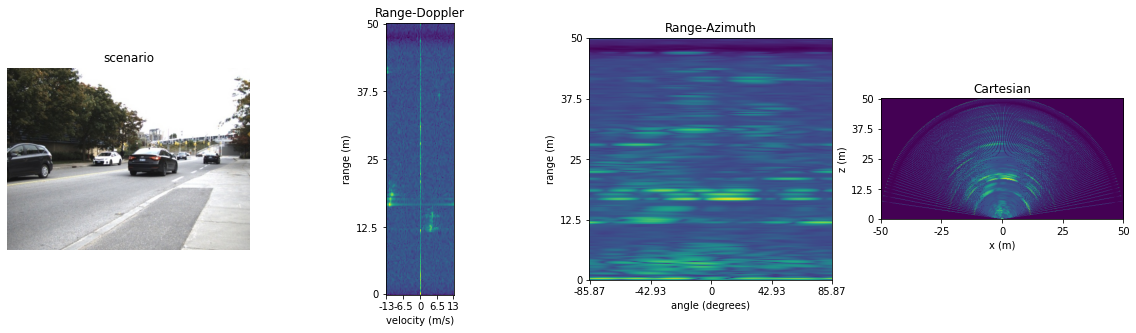

  3%|▎         | 1/32 [00:03<01:42,  3.30s/it]

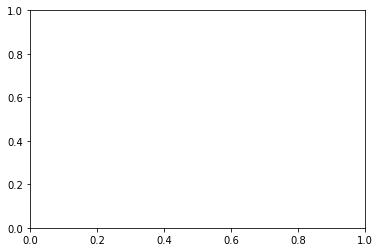

  6%|▋         | 2/32 [00:06<01:31,  3.05s/it]

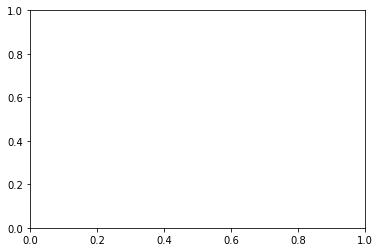

  9%|▉         | 3/32 [00:09<01:28,  3.05s/it]

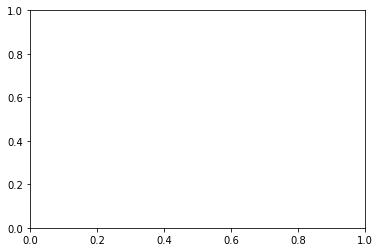

 12%|█▎        | 4/32 [00:12<01:23,  3.00s/it]

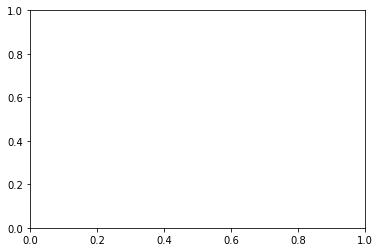

 16%|█▌        | 5/32 [00:15<01:21,  3.00s/it]

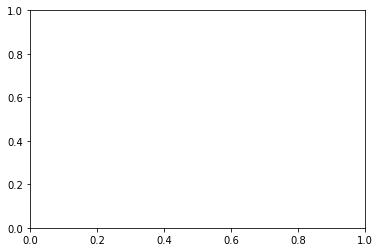

 19%|█▉        | 6/32 [00:18<01:20,  3.10s/it]

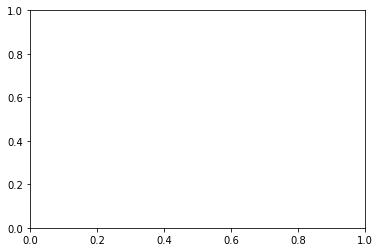

 22%|██▏       | 7/32 [00:21<01:16,  3.04s/it]

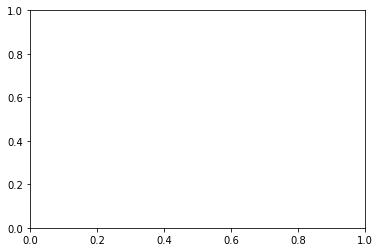

 25%|██▌       | 8/32 [00:24<01:12,  3.01s/it]

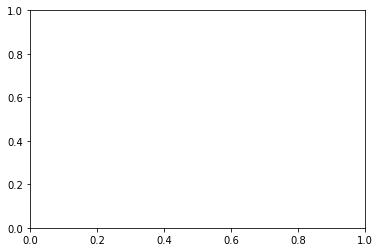

 28%|██▊       | 9/32 [00:27<01:08,  2.99s/it]

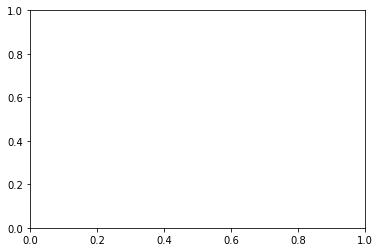

 31%|███▏      | 10/32 [00:30<01:09,  3.15s/it]

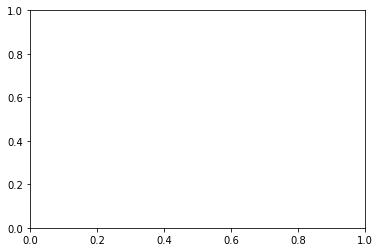

 34%|███▍      | 11/32 [00:33<01:04,  3.08s/it]

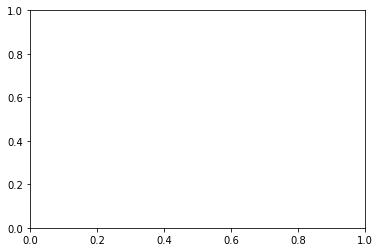

 38%|███▊      | 12/32 [00:36<01:01,  3.07s/it]

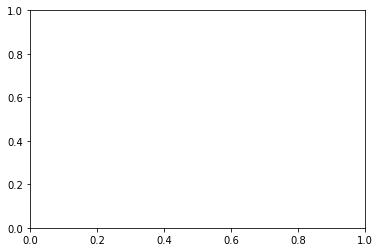

 41%|████      | 13/32 [00:39<00:57,  3.04s/it]

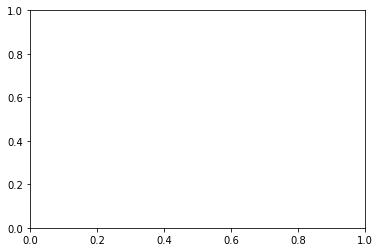

 44%|████▍     | 14/32 [00:42<00:54,  3.03s/it]

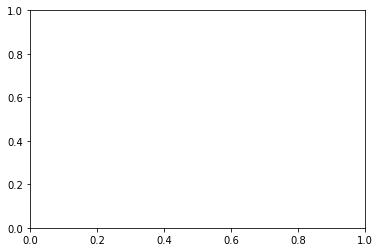

 47%|████▋     | 15/32 [00:45<00:51,  3.02s/it]

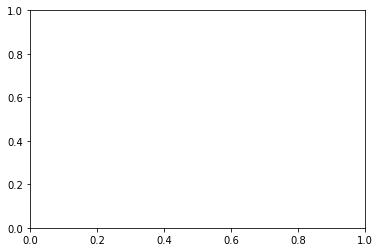

 50%|█████     | 16/32 [00:48<00:48,  3.00s/it]

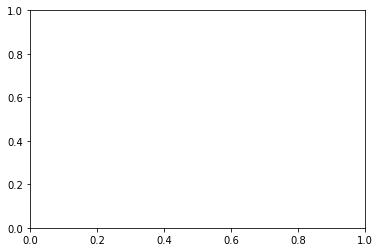

 53%|█████▎    | 17/32 [00:51<00:45,  3.04s/it]

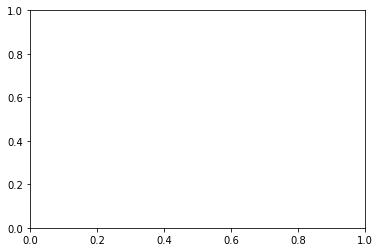

 56%|█████▋    | 18/32 [00:54<00:42,  3.03s/it]

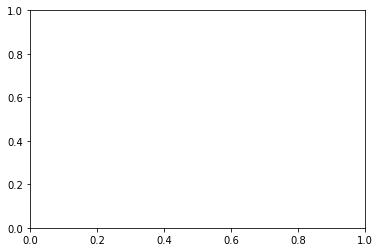

 59%|█████▉    | 19/32 [00:58<00:41,  3.18s/it]

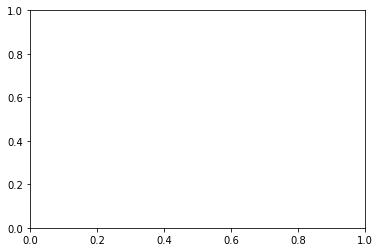

 62%|██████▎   | 20/32 [01:01<00:37,  3.11s/it]

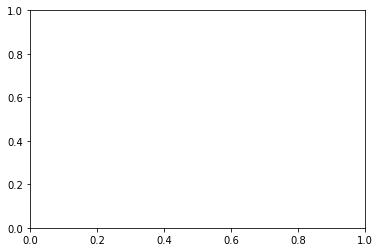

 66%|██████▌   | 21/32 [01:04<00:33,  3.07s/it]

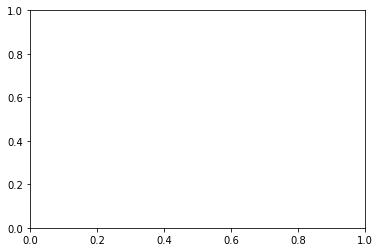

 69%|██████▉   | 22/32 [01:07<00:30,  3.02s/it]

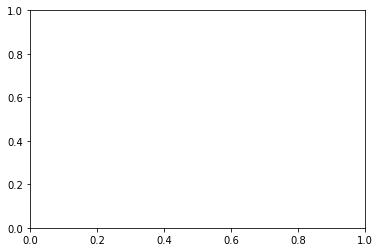

 72%|███████▏  | 23/32 [01:10<00:26,  3.00s/it]

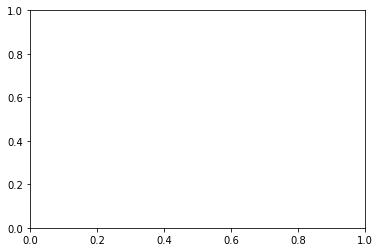

 75%|███████▌  | 24/32 [01:13<00:23,  2.99s/it]

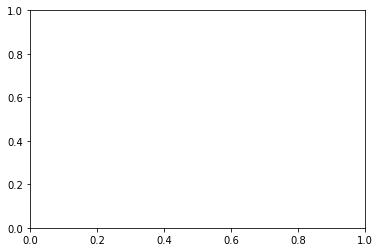

 78%|███████▊  | 25/32 [01:16<00:20,  2.97s/it]

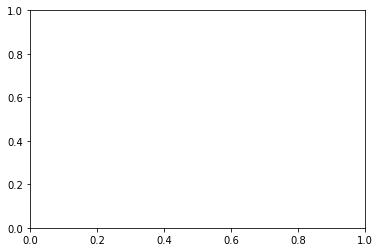

 81%|████████▏ | 26/32 [01:18<00:17,  2.96s/it]

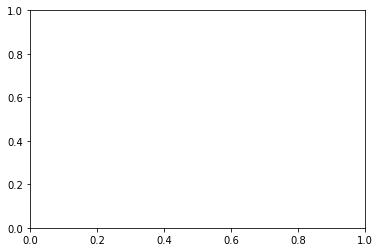

 84%|████████▍ | 27/32 [01:21<00:14,  2.95s/it]

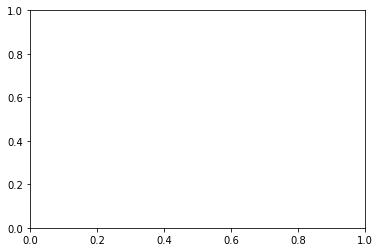

 88%|████████▊ | 28/32 [01:25<00:12,  3.02s/it]

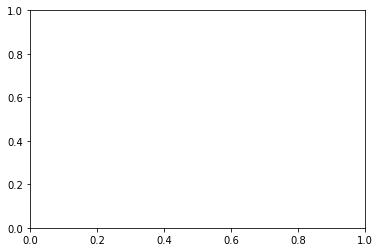

 91%|█████████ | 29/32 [01:28<00:09,  3.01s/it]

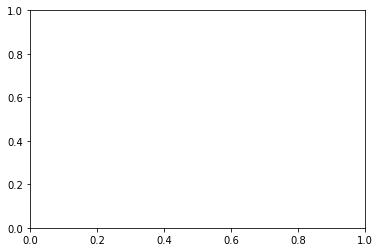

 94%|█████████▍| 30/32 [01:31<00:06,  3.01s/it]

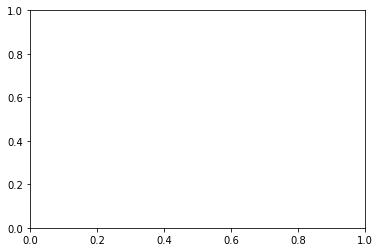

 97%|█████████▋| 31/32 [01:34<00:03,  3.00s/it]

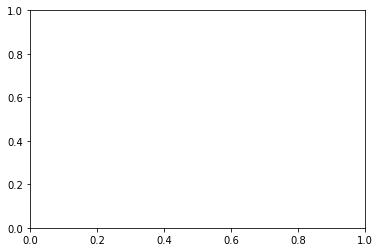

100%|██████████| 32/32 [01:37<00:00,  3.03s/it]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import util.loader as loader
import util.helper as helper
import util.drawer as drawer

def process(RAD_filename, frame_id, config_data, config_radar, colors,fig, axes, interpolation=15):
    RAD = loader.readRAD(RAD_filename)
    prefix = config_data["test_set_dir"]
    img_file = loader.imgfileFromRADfile(RAD_filename, prefix)
    stereo_left_image = loader.readStereoLeft(img_file)
    RA = helper.getLog(helper.getSumDim(helper.getMagnitude(RAD, power_order=2), target_axis=-1), scalar=10, log_10=True)
    RD = helper.getLog(helper.getSumDim(helper.getMagnitude(RAD, power_order=2), target_axis=1), scalar=10, log_10=True)
    RA_cart = helper.toCartesianMask(RA, config_radar,gapfill_interval_num=interpolation)
    RA_img = helper.norm2Image(RA)[..., :3] 
    RD_img = helper.norm2Image(RD)[..., :3]
    RA_cart_img = helper.norm2Image(RA_cart)[..., :3]
    drawer.clearAxes(axes)
    drawer.imgPlot(stereo_left_image, axes[0], None, None, "scenario")
    drawer.imgPlot(RD_img, axes[1], None, 1, "RD") 
    drawer.imgPlot(RA_img, axes[2], None, 1, "RA") 
    drawer.imgPlot(RA_cart_img, axes[3], None, 1, "Cartesian") 
    plt.savefig(os.path.join("/content/gdrive/MyDrive/RADDet/images/heat_maps", "%.6d.png"%(frame_id)))
    drawer.keepDrawing(fig, 0.05)
           
def main():
    config = loader.readConfig()
    config_data = config["DATA"]
    config_radar = config["RADAR_CONFIGURATION"]
    colors = loader.randomColors(config_data["all_classes"])
    fig, axes = drawer.prepareFigure(4, figsize=(20, 5))
    interpolation = 1
    all_RAD_files = glob(os.path.join(config_data["test_set_dir"], "RAD/*/*.npy"))
    for i in tqdm(range(len(all_RAD_files))):
        RAD_filename = all_RAD_files[i]
        process(
                RAD_filename=RAD_filename, \
                frame_id = i, \
                config_data=config_data, \
                config_radar=config_radar, \
                colors=colors, \
                fig=fig, \
                axes=axes, \
                interpolation=interpolation)

main()